# Challenge de Python para Rocking Data

## Consigna:

Tecompartimos un dataset de marketing de un banco portugues. 

El objetivo es evaluar los datos, realizando un análisis descriptivo y evaluar una serie de modelos de clasificación y elegir el que mejor  resultados obtiene prediciendo la columna 21 que representa si se suscribe al servicio correspondiente.

## Se valora:

La descripción del análisis realizado

Las conclusiones de las decisiones tomadas

La prolijidad del código.

## Entregables:

Un notebook con el codigo correspondiente.

Un video explicando las conclusiones de no mas de 10min

## DICCIONARIO DE DATOS:
### Datos de clientes:

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

### Related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 
then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not 
previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

### Social and economic context attributes

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

# Resolución:

In [1]:
import pandas as pd                                                                     
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error     #Comenzamos importando las librerías necesarias
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('bank_data.csv',sep=';')         #Abrimos el dataset y realizamos una impresión de checkeo
df = data.copy()
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
target = {'no':0,'yes':1} 
df = df.replace({'y':target})       #Numeramos la columna objetivo para poder observarla en matrices de correlación

C:\Users\uriel\AppData\Local\Temp\ipykernel_3500\2374229398.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()                                 #Graficamos la matriz de correlación inicial


<Axes: >

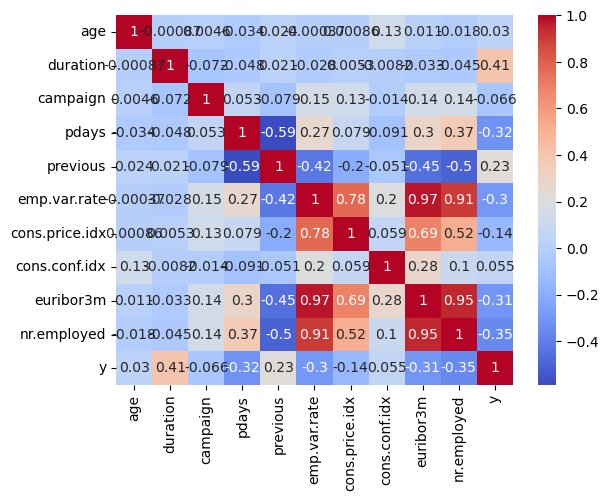

In [4]:
corr_matrix = df.corr()                                 #Graficamos la matriz de correlación inicial
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Ya podemos observar qué columnas, a priori, impactan más en nuestro resultado. Sin embargo la mayor parte de las columnas no se puede ver en la matriz, puesto que no contienen variables numéricas

In [5]:
nan_count = df.isna().sum()     #Comprobamos la cantidad de valores faltantes. Desde la premisa no debería haber, siendo reemplazados por "unknown" en la Extracción
print(nan_count)          

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [6]:
df.describe()           #Obtenemos un pantallazo de nuestros datos numéricos

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [7]:
for col in df.columns: print(col,':',np.sort(df[col].unique()))     #Obtenemos los valores únicos, esto a fin de luego analizar las variables categóricas principalmente

age : [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 89 91 92 94 95 98]
job : ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital : ['divorced' 'married' 'single' 'unknown']
education : ['basic.4y' 'basic.6y' 'basic.9y' 'high.school' 'illiterate'
 'professional.course' 'university.degree' 'unknown']
default : ['no' 'unknown' 'yes']
housing : ['no' 'unknown' 'yes']
loan : ['no' 'unknown' 'yes']
contact : ['cellular' 'telephone']
month : ['apr' 'aug' 'dec' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
day_of_week : ['fri' 'mon' 'thu' 'tue' 'wed']
duration : [   0    1    2 ... 3785 4199 4918]
campaign : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 37 39 40 

Analizaremos primero qué impacto tienen las variables en nuesto objetivo, desde una observación estratificada. Nuestra atención estará sobre los conteos y los promedios. Gracias a que hemos convertido a unos y ceros la variable objetivo, el promedio muestra la probabilidad de que el cliente suscriba a un plazo fijo en el estrato observado

In [8]:
binned = df.copy()                                                          #Análisis Estratificado de Employment Variation Rate 
binned['emp.var.rate_bins'] = pd.cut(x=binned['emp.var.rate'], bins=5)
binned.groupby('emp.var.rate_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
emp.var.rate_bins,,,,,,,,
"(-3.405, -2.44]",2906.0,0.390915,0.488039,0.0,0.0,0.0,1.0,1.0
"(-2.44, -1.48]",9957.0,0.187205,0.390096,0.0,0.0,0.0,0.0,1.0
"(-1.48, -0.52]",635.0,0.474016,0.499718,0.0,0.0,0.0,1.0,1.0
"(-0.52, 0.44]",3693.0,0.063092,0.243162,0.0,0.0,0.0,0.0,1.0
"(0.44, 1.4]",23997.0,0.046089,0.209682,0.0,0.0,0.0,0.0,1.0


Podemos observar en general una correlación negativa, siendo considerable el aumento en el promedio cuando la variable adopta valores negativos.

In [9]:
binned = df.copy()                                                          #Análisis Estratificado de Euribor 3 Month Rate
binned['euribor3m_bins'] = pd.cut(x=binned['euribor3m'], bins=10)
binned.groupby('euribor3m_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
euribor3m_bins,,,,,,,,
"(0.63, 1.075]",4242.0,0.457567,0.498255,0.0,0.0,0.0,1.0,1.0
"(1.075, 1.516]",8985.0,0.137674,0.344577,0.0,0.0,0.0,0.0,1.0
"(1.516, 1.957]",271.0,0.453875,0.498789,0.0,0.0,0.0,1.0,1.0
"(1.957, 2.398]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(2.398, 2.839]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(2.839, 3.281]",1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
"(3.281, 3.722]",7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(3.722, 4.163]",2950.0,0.050508,0.219029,0.0,0.0,0.0,0.0,1.0
"(4.163, 4.604]",649.0,0.052388,0.222981,0.0,0.0,0.0,0.0,1.0


In [10]:
binned = df.copy()                                                          #Análisis Estratificado de Euribor 3 Month Rate
binned['nr.employed_bins'] = pd.cut(x=binned['nr.employed'], bins=10)
binned.groupby('nr.employed_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
nr.employed_bins,,,,,,,,
"(4963.336, 4990.05]",635.0,0.474016,0.499718,0.0,0.0,0.0,1.0,1.0
"(4990.05, 5016.5]",1423.0,0.542516,0.498364,0.0,0.0,1.0,1.0,1.0
"(5016.5, 5042.95]",1243.0,0.436042,0.496092,0.0,0.0,0.0,1.0,1.0
"(5042.95, 5069.4]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(5069.4, 5095.85]",1663.0,0.357186,0.479314,0.0,0.0,0.0,1.0,1.0
"(5095.85, 5122.3]",8534.0,0.127959,0.334063,0.0,0.0,0.0,0.0,1.0
"(5122.3, 5148.75]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(5148.75, 5175.2]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(5175.2, 5201.65]",11456.0,0.041288,0.198965,0.0,0.0,0.0,0.0,1.0


In [11]:
binned = df.copy()                                                          #Análisis Estratificado de Euribor 3 Month Rate
binned['cons.price.idx_bins'] = pd.cut(x=binned['cons.price.idx'], bins=10)
binned.groupby('cons.price.idx_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
cons.price.idx_bins,,,,,,,,
"(92.198, 92.458]",1484.0,0.370620,0.483134,0.0,0.0,0.0,1.0,1.0
"(92.458, 92.714]",707.0,0.455446,0.498364,0.0,0.0,0.0,1.0,1.0
"(92.714, 92.971]",6801.0,0.134539,0.341256,0.0,0.0,0.0,0.0,1.0
"(92.971, 93.227]",6074.0,0.104050,0.305351,0.0,0.0,0.0,0.0,1.0
"(93.227, 93.484]",5439.0,0.077404,0.267256,0.0,0.0,0.0,0.0,1.0
"(93.484, 93.741]",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(93.741, 93.997]",14901.0,0.060936,0.239220,0.0,0.0,0.0,0.0,1.0
"(93.997, 94.254]",1076.0,0.513941,0.500038,0.0,0.0,1.0,1.0,1.0
"(94.254, 94.51]",4374.0,0.042981,0.202838,0.0,0.0,0.0,0.0,1.0


In [12]:
binned = df.copy()                                                          #Análisis Estratificado de Euribor 3 Month Rate
binned['cons.conf.idx_bins'] = pd.cut(x=binned['cons.conf.idx'], bins=10)
binned.groupby('cons.conf.idx_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
cons.conf.idx_bins,,,,,,,,
"(-50.824, -48.41]",614.0,0.451140,0.498013,0.0,0.0,0.0,1.0,1.0
"(-48.41, -46.02]",8252.0,0.117063,0.321514,0.0,0.0,0.0,0.0,1.0
"(-46.02, -43.63]",10.0,0.100000,0.316228,0.0,0.0,0.0,0.0,1.0
"(-43.63, -41.24]",14675.0,0.053492,0.225021,0.0,0.0,0.0,0.0,1.0
"(-41.24, -38.85]",1534.0,0.463494,0.498828,0.0,0.0,0.0,1.0,1.0
"(-38.85, -36.46]",536.0,0.503731,0.500453,0.0,0.0,1.0,1.0,1.0
"(-36.46, -34.07]",13376.0,0.056669,0.231217,0.0,0.0,0.0,0.0,1.0
"(-34.07, -31.68]",350.0,0.440000,0.497098,0.0,0.0,0.0,1.0,1.0
"(-31.68, -29.29]",1394.0,0.385940,0.486991,0.0,0.0,0.0,1.0,1.0


Observamos correlaciones similares en las variables, lo cual es esperable teniendo en cuenta que los 5 indicadores macroeconómicos que se presentan están íntimamente relacionados. Esto se refuerza al ver la matriz de correlación. De momento la única observación que realizaremos es la relación entre el índice de empleo y la suscripción a depósitos a plazo fijo. Esto podría explicarse en las indemnizaciones por despidos, que la gente tiende a colocar en plazo fijo para no tener ese dinero congelado.

In [13]:
binned = df.copy()
binned['age_bins'] = pd.cut(x=binned['age'], bins=[17, 19, 29, 39, 49, 59, 69, 79, 89,99])     #Análisis Estratificado de Edad
binned.groupby('age_bins').describe()['y'][{'mean','count'}]

C:\Users\uriel\AppData\Local\Temp\ipykernel_3500\1939357431.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  binned.groupby('age_bins').describe()['y'][{'mean','count'}]


,mean,count
age_bins,,
"(17, 19]",0.457143,70.0
"(19, 29]",0.158742,5594.0
"(29, 39]",0.101252,16938.0
"(39, 49]",0.079232,10526.0
"(49, 59]",0.101574,6862.0
"(59, 69]",0.346685,724.0
"(69, 79]",0.451411,319.0
"(79, 89]",0.514286,140.0
"(89, 99]",0.500000,10.0


Observamos aquí un aumento en las suscripciones a plazo fijo (en adelante le llamaremos "PF") hacia los más jóvenes y los más ancianos

In [14]:
binned = df.copy()
binned['duration_bins'] = pd.cut(x=binned['duration'], bins=[-1,60,120,180,240,300,360,420,480,540,600,binned['duration'].max()]) #Análisis Estratificado de Duration
binned.groupby('duration_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
duration_bins,,,,,,,,
"(-1, 60]",4286.0,0.000233,0.015275,0.0,0.0,0.0,0.0,1.0
"(60, 120]",8631.0,0.019117,0.136945,0.0,0.0,0.0,0.0,1.0
"(120, 180]",7788.0,0.051104,0.220225,0.0,0.0,0.0,0.0,1.0
"(180, 240]",5475.0,0.089132,0.284961,0.0,0.0,0.0,0.0,1.0
"(240, 300]",3804.0,0.122503,0.327909,0.0,0.0,0.0,0.0,1.0
"(300, 360]",2684.0,0.135618,0.342447,0.0,0.0,0.0,0.0,1.0
"(360, 420]",1900.0,0.167895,0.373871,0.0,0.0,0.0,0.0,1.0
"(420, 480]",1332.0,0.195946,0.397076,0.0,0.0,0.0,0.0,1.0
"(480, 540]",1014.0,0.243590,0.429460,0.0,0.0,0.0,0.0,1.0


Podemos ver un aumento en PF de acuerdo a un mayor tiempo de contacto. Podríamos trazar aquí una barrera en los 4 minutos, momento en el que se supera el promedio de ventas. Si bien el promedio de duración de las llamadas alcanza esa barrera, el 50% no dura más de 3 minutos. Por ello podríamos sugerir a los agentes de telemarketing el objetivo de alcanzar los 4 minutos en llamada, con el fin de aumentar las probabilidades de éxito

In [15]:
binned = df.copy()
binned['campaign_bins'] = pd.cut(x=binned['campaign'], bins=[0,1,2,3,4,9,19,29,39,49,binned['campaign'].max()])     #Análisis Estratificado de Campaign
binned.groupby('campaign_bins').describe()['y']

,count,mean,std,min,25%,50%,75%,max
campaign_bins,,,,,,,,
"(0, 1]",17642.0,0.130371,0.336720,0.0,0.0,0.0,0.0,1.0
"(1, 2]",10570.0,0.114570,0.318517,0.0,0.0,0.0,0.0,1.0
"(2, 3]",5341.0,0.107471,0.309740,0.0,0.0,0.0,0.0,1.0
"(3, 4]",2651.0,0.093927,0.291782,0.0,0.0,0.0,0.0,1.0
"(4, 9]",3890.0,0.068638,0.252869,0.0,0.0,0.0,0.0,1.0
"(9, 19]",907.0,0.041896,0.200463,0.0,0.0,0.0,0.0,1.0
"(19, 29]",147.0,0.006803,0.082479,0.0,0.0,0.0,0.0,1.0
"(29, 39]",32.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"(39, 49]",7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


Aquí observamos una caída en la efectividad de la campaña a medida que aumenta la cantidad de contactos con el cliente, siendo ideal no realizar más de 3 en la misma campaña

In [16]:
binned = df.copy()
binned['pdays_bins'] = pd.cut(x=binned['pdays'], bins=[0,28,binned['pdays'].max()])     #Análisis Estratificado de Pdays
print(binned.groupby('pdays_bins').describe()['y'])
print(df.groupby(['poutcome']).describe()['y'])                     #Análisis de Past Outcome
print(df.groupby(['previous']).describe()['y'])                     #Análisis de Previous

              count      mean       std  min  25%  50%  75%  max
pdays_bins                                                      
(0, 28]      1500.0  0.638000  0.480739  0.0  0.0  1.0  1.0  1.0
(28, 999]   39673.0  0.092582  0.289849  0.0  0.0  0.0  0.0  1.0
               count      mean       std  min  25%  50%  75%  max
poutcome                                                         
failure       4252.0  0.142286  0.349384  0.0  0.0  0.0  0.0  1.0
nonexistent  35563.0  0.088322  0.283767  0.0  0.0  0.0  0.0  1.0
success       1373.0  0.651129  0.476787  0.0  0.0  1.0  1.0  1.0
            count      mean       std  min   25%  50%  75%  max
previous                                                       
0         35563.0  0.088322  0.283767  0.0  0.00  0.0  0.0  1.0
1          4561.0  0.212015  0.408780  0.0  0.00  0.0  0.0  1.0
2           754.0  0.464191  0.499047  0.0  0.00  0.0  1.0  1.0
3           216.0  0.592593  0.492493  0.0  0.00  1.0  1.0  1.0
4            70.0  0.54285

Podemos notar un claro éxito en volver a contactar clientes de campañas previas

In [17]:
df.groupby(['job']).describe()['y'].sort_values('mean')['mean']                    #Análisis de Job

job
blue-collar      0.068943
services         0.081381
entrepreneur     0.085165
housemaid        0.100000
self-employed    0.104856
technician       0.108260
unknown          0.112121
management       0.112175
admin.           0.129726
unemployed       0.142012
retired          0.252326
student          0.314286
Name: mean, dtype: float64

Podemos observar aquí una distribución en las probabilidades de PF según el trabajo el cliente. Cabe remarcar la popularidad entre estudiantes y jubilados, en contraste con los obreros. Esto puede tener además una correlación con la edad 

In [18]:
print(df.groupby(['housing']).describe()['y'])                 #Análisis de Housing
print(df.groupby(['loan']).describe()['y'])                    #Análisis de Loan
print(df.groupby(['education']).describe()['y'])               #Análisis de Education
print(df.groupby(['marital']).describe()['y'])               #Análisis de Education
print(df.groupby(['default']).describe()['y'])                    #Análisis de Past Default)

           count      mean       std  min  25%  50%  75%  max
housing                                                      
no       18622.0  0.108796  0.311392  0.0  0.0  0.0  0.0  1.0
unknown    990.0  0.108081  0.310639  0.0  0.0  0.0  0.0  1.0
yes      21576.0  0.116194  0.320465  0.0  0.0  0.0  0.0  1.0
           count      mean       std  min  25%  50%  75%  max
loan                                                         
no       33950.0  0.113402  0.317088  0.0  0.0  0.0  0.0  1.0
unknown    990.0  0.108081  0.310639  0.0  0.0  0.0  0.0  1.0
yes       6248.0  0.109315  0.312059  0.0  0.0  0.0  0.0  1.0
                       count      mean       std  min  25%  50%  75%  max
education                                                                
basic.4y              4176.0  0.102490  0.303328  0.0  0.0  0.0  0.0  1.0
basic.6y              2292.0  0.082024  0.274462  0.0  0.0  0.0  0.0  1.0
basic.9y              6045.0  0.078246  0.268581  0.0  0.0  0.0  0.0  1.0
high.schoo

De estos datos obtenemos una distribución bastante uniforme, por lo que no resultan significativos. Podemos mencionar aún una mayor venta de PF en clientes con mayor grado de educación alcanzado

In [19]:
df.groupby(['contact']).describe()['y']             #Análisis de Contact

,count,mean,std,min,25%,50%,75%,max
contact,,,,,,,,
cellular,26144.0,0.147376,0.354487,0.0,0.0,0.0,0.0,1.0
telephone,15044.0,0.052313,0.222665,0.0,0.0,0.0,0.0,1.0


Podemos ver aquí una clara diferencia en efectividad con respecto al canal de venta

In [20]:
print(df.groupby(['day_of_week']).describe()['y'].sort_values('mean'))  #Análisis de day_of_week

              count      mean       std  min  25%  50%  75%  max
day_of_week                                                     
mon          8514.0  0.099483  0.299327  0.0  0.0  0.0  0.0  1.0
fri          7827.0  0.108087  0.310511  0.0  0.0  0.0  0.0  1.0
wed          8134.0  0.116671  0.321047  0.0  0.0  0.0  0.0  1.0
tue          8090.0  0.117800  0.322391  0.0  0.0  0.0  0.0  1.0
thu          8623.0  0.121188  0.326364  0.0  0.0  0.0  0.0  1.0


La distribución por día de contacto es bastante uniforme

In [21]:
print((df.groupby(['month']).describe()['y'].sort_values('count')))      #Análisis de Month

         count      mean       std  min  25%  50%  75%  max
month                                                      
dec      182.0  0.489011  0.501258  0.0  0.0  0.0  1.0  1.0
mar      546.0  0.505495  0.500428  0.0  0.0  1.0  1.0  1.0
sep      570.0  0.449123  0.497842  0.0  0.0  0.0  1.0  1.0
oct      718.0  0.438719  0.496576  0.0  0.0  0.0  1.0  1.0
apr     2632.0  0.204787  0.403623  0.0  0.0  0.0  0.0  1.0
nov     4101.0  0.101439  0.301946  0.0  0.0  0.0  0.0  1.0
jun     5318.0  0.105115  0.306730  0.0  0.0  0.0  0.0  1.0
aug     6178.0  0.106021  0.307890  0.0  0.0  0.0  0.0  1.0
jul     7174.0  0.090466  0.286868  0.0  0.0  0.0  0.0  1.0
may    13769.0  0.064347  0.245380  0.0  0.0  0.0  0.0  1.0


Podemos observar una variación en el éxito de las campañas por mes, pero también una correlación negativa con respecto a la cantidad de contactos en el mes. Puede ser de utilidad para las predicciones, pero no aporta datos significativos para el análisis

In [22]:
#Dada la necesidad de reemplazar las variables categóricas por numéricas y estratificar algunas, crearemos diccionarios y listas para tal fin

#IMPORTANTE:    El criterio de numeración de las variables tiene como base las diferencias de probabilidad de PF para cada estrato.
#               Para algunos casos como marital, loan, contact; se utilizarán números enteros relacionados con las probabilidades de PF, pero  
#               designados completamente a ojo.
#               Para education se utilizará una estratificación simulando "niveles"
#               Para past days se separará marcando la existencia o no del contacto previo
#               Para duration simplemente se convertirán los segundos en minutos, clasificando como "11" todas las duraciones mayores a 10 minutos
#               Para edades y trabajos se reemplazarán los valores por las probabilidades observadas en cada estrato en los análisis estratificados
#               Según esto, edades y trabajos se fijan manualmente a partir de los datos observados, en un desarrollo posterior se deberían calcular.


job_dict = {'admin.': 0.129, 'blue-collar':0.068, 'entrepreneur':0.085, 'housemaid':0.100, 'management':0.112, 'retired':0.252, 
            'self-employed':0.104, 'services':0.081, 'student':0.314, 'technician':0.108, 'unemployed':0.142, 'unknown': 0.112}
marital_dict = {'divorced':1, 'married':1, 'single':2, 'unknown':2}
education_dict = {'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 'high.school':4, 'illiterate':0, 'professional.course':5, 'university.degree':6, 'unknown':3.5}
loan_dict = {'no':3, 'unknown':2, 'yes':1}
contact_dict = {'telephone':1,'cellular':3}
month_dict = {'may':1,'jul':2,'aug':3,'jun':3,'nov':3,'apr':4,'oct':8,'sep':8,'dec':9,'mar':10}
day_week_dict = {'mon':1,'tue':2,'wed':3,'thu':2,'fri':1}
past_outcome = {'failure':1,'success':2,'nonexistent':0}

past_days = [1,0]
ages = [45,15,10,7,10,34,45,51,50]
minutes = [1,2,3,4,5,6,7,8,9,10,11]

In [23]:
#Reemplazamos, y estratificamos

df2 = df.copy()
df2 = df2.replace({'job':job_dict,'marital':marital_dict,'education':education_dict,'default':loan_dict,'housing':loan_dict,'loan':loan_dict,'contact':contact_dict,
                    'month':month_dict,'day_of_week':day_week_dict,'poutcome':past_outcome})
df2['binned_age_prob'] = pd.cut(x=df2['age'], bins=[16, 19, 29, 39, 49, 59, 69, 79, 89 ,99],labels = ages,ordered=False)
df2['binned_age_prob']= df2['binned_age_prob'].astype(int) 
df2['minutes'] = pd.cut(x=df2['duration'], bins=[-1,60,120,180,240,300,360,420,480,540,600,df2['duration'].max()],labels = minutes,ordered=False)
df2['minutes']= df2['minutes'].astype(int) 
df2['pdays_bins'] = pd.cut(x=df2['pdays'], bins=[-1,28,df2['pdays'].max()],labels=past_days) 
df2['pdays_bins']= df2['pdays_bins'].astype(int) 
df2['campaign_bins'] = pd.cut(x=df2['campaign'], bins=[-1,4,df2['campaign'].max()],labels = past_days)
df2['campaign_bins'] = df2['campaign_bins'].astype(int) 
df2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,binned_age_prob,minutes,pdays_bins,campaign_bins
0,56,0.100,1,1.0,3,3,3,1,1,1,...,1.1,93.994,-36.4,4.857,5191.0,0,10,5,0,1
1,57,0.081,1,4.0,2,3,3,1,1,1,...,1.1,93.994,-36.4,4.857,5191.0,0,10,3,0,1
2,37,0.081,1,4.0,3,1,3,1,1,1,...,1.1,93.994,-36.4,4.857,5191.0,0,10,4,0,1
3,40,0.129,1,2.0,3,3,3,1,1,1,...,1.1,93.994,-36.4,4.857,5191.0,0,7,3,0,1
4,56,0.081,1,4.0,3,3,1,1,1,1,...,1.1,93.994,-36.4,4.857,5191.0,0,10,6,0,1


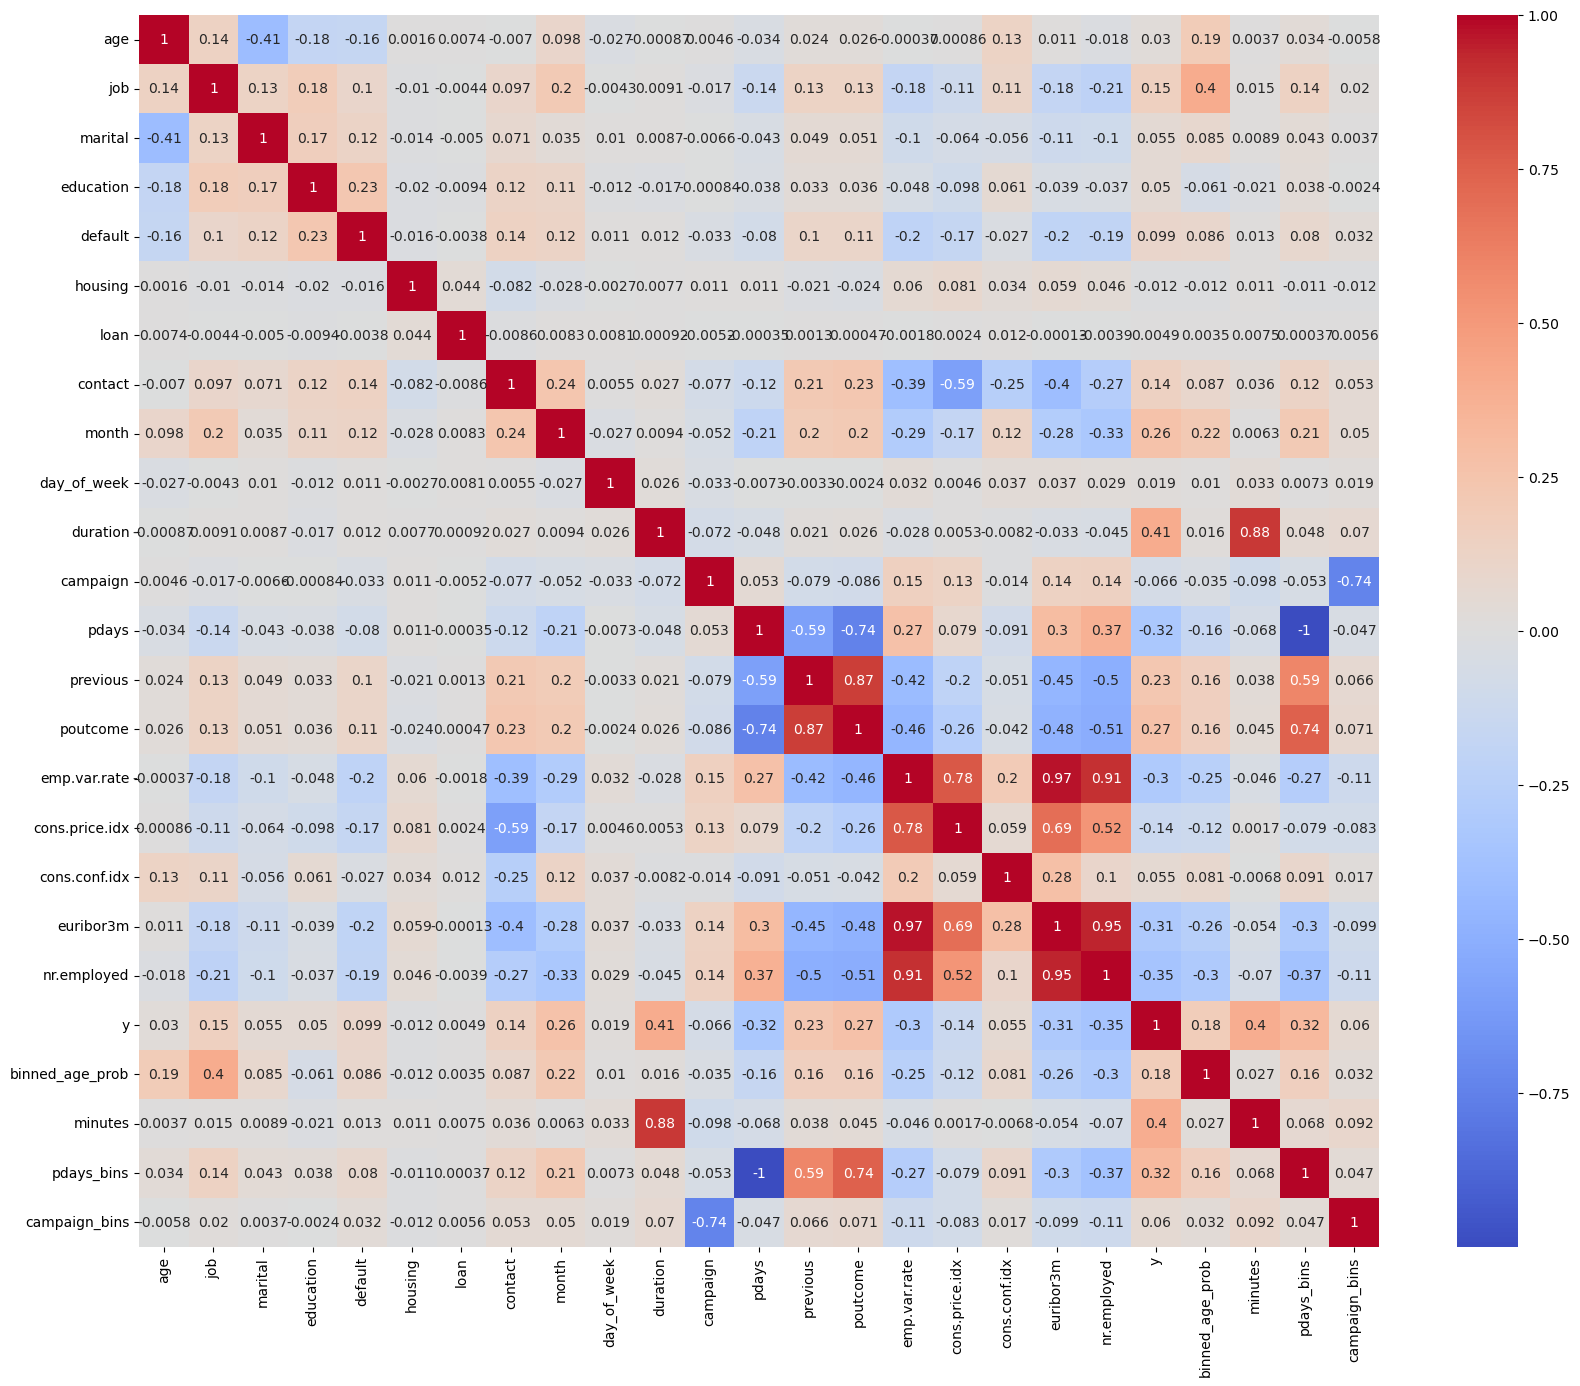

In [24]:
corr_matrix2 = df2.corr()                                 #Creamos y graficamos la matriz de correlación con las nuevas columnas

fig, ax = plt.subplots(figsize=(20, 16), dpi=100)
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', ax=ax)

plt.show()

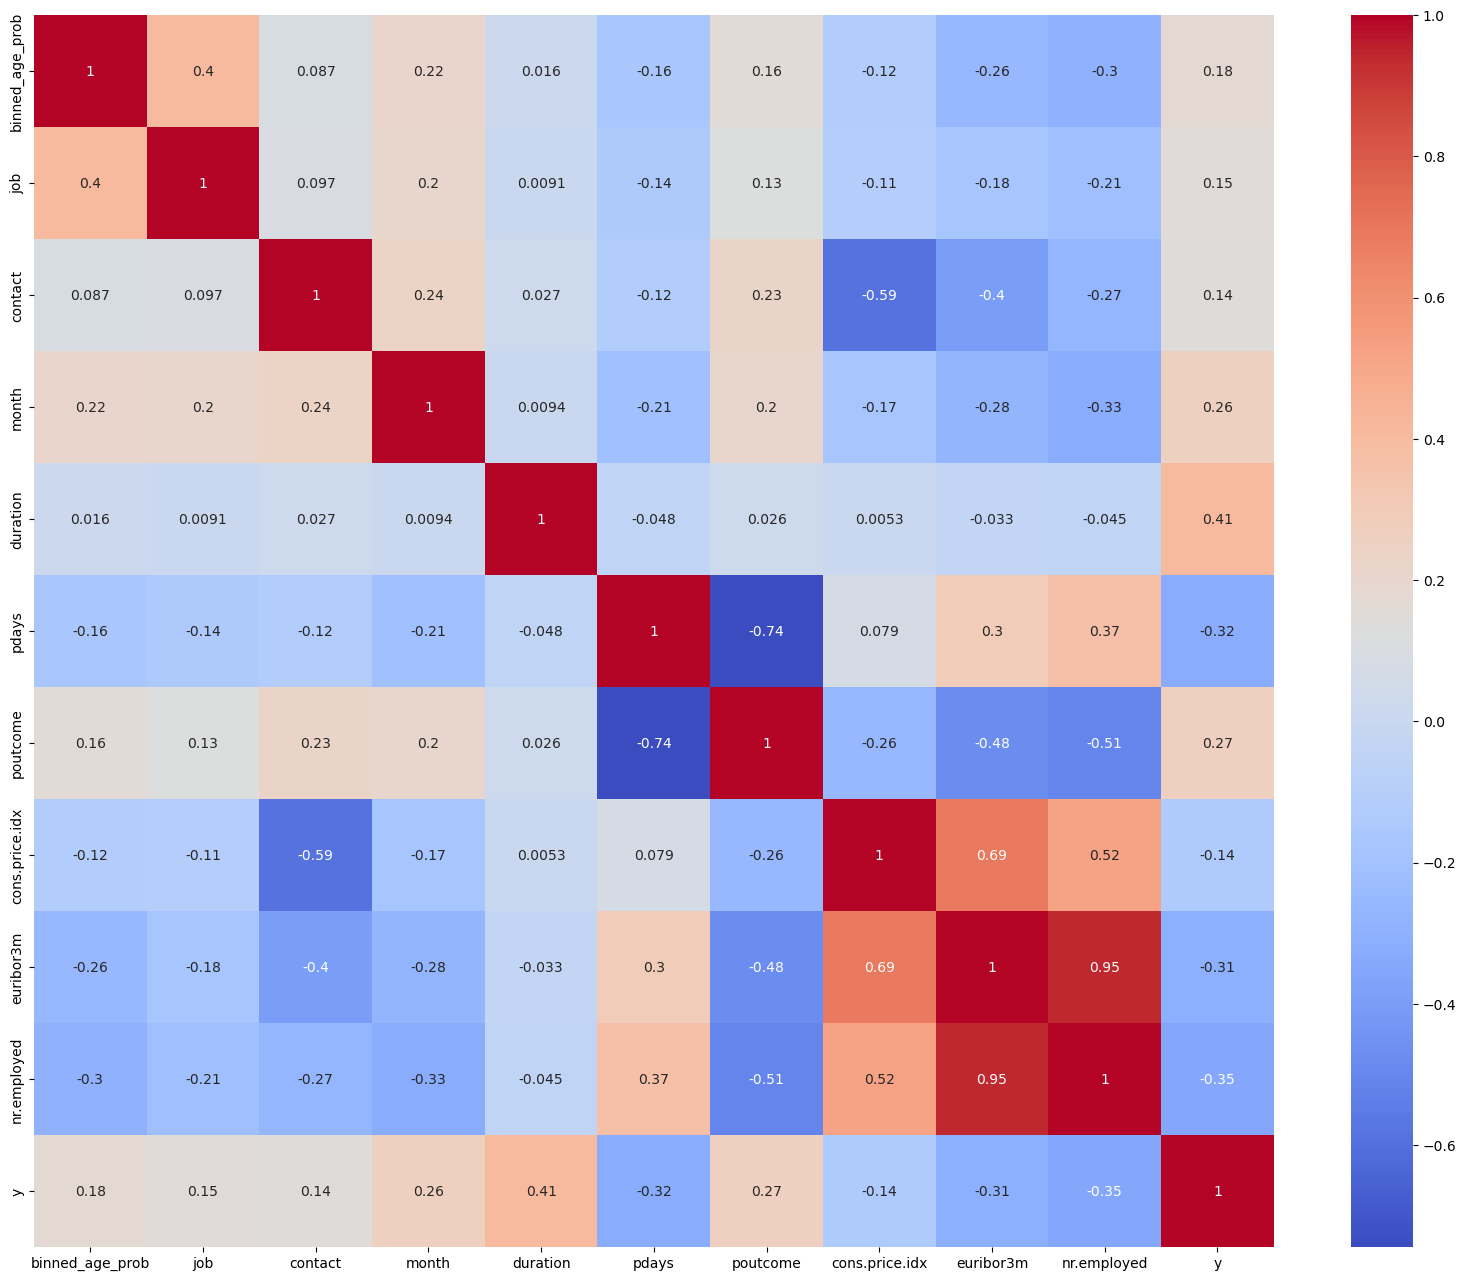

In [25]:
#Filtramos las columnas que utilizaremos, por presentar correlaciones más marcadas, y graficamos nuevamente

df3 = pd.DataFrame(df2.loc[:,['binned_age_prob','job','contact','month','duration','pdays','poutcome','cons.price.idx','euribor3m','nr.employed','y']])

corr_matrix2 = df3.corr()                               

fig, ax = plt.subplots(figsize=(20, 16), dpi=100)
sns.heatmap(corr_matrix2, annot=True, cmap='coolwarm', ax=ax)

plt.show()

Nos han quedado menos variables, pero con un mejor grado de correlación en general

In [26]:
x = df3.copy()                          #Preparamos los datasets de entrenamiento y testeo
x = x.drop(columns='y').values
y = df3['y'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression()

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(reg, param_grid=param_grid, cv=5)

grid_search.fit(x_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)



c:\Users\uriel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\uriel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\uriel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\uriel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\uriel\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\uriel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co

Best hyperparameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score:  0.9071139205621757


c:\Users\uriel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     25580
           1       0.65      0.38      0.48      3251

    accuracy                           0.91     28831
   macro avg       0.79      0.68      0.71     28831
weighted avg       0.89      0.91      0.90     28831



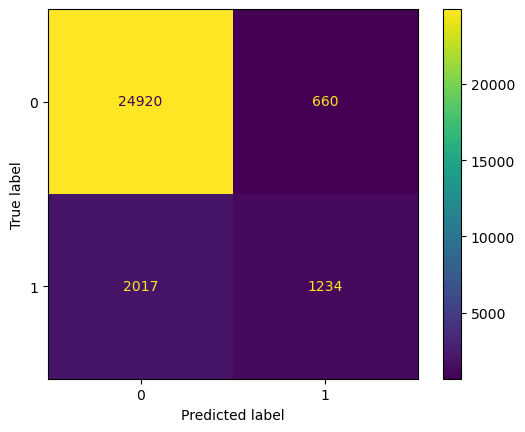

In [32]:
reg = LogisticRegression(C= 0.1, penalty= 'l2', solver= 'liblinear')

reg.fit(x_train,y_train)

y_train_pred1 = reg.predict(x_train)

print(classification_report(y_train, y_train_pred1))

matrix = confusion_matrix(y_train, y_train_pred1)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10968
           1       0.67      0.39      0.50      1389

    accuracy                           0.91     12357
   macro avg       0.80      0.68      0.72     12357
weighted avg       0.90      0.91      0.90     12357



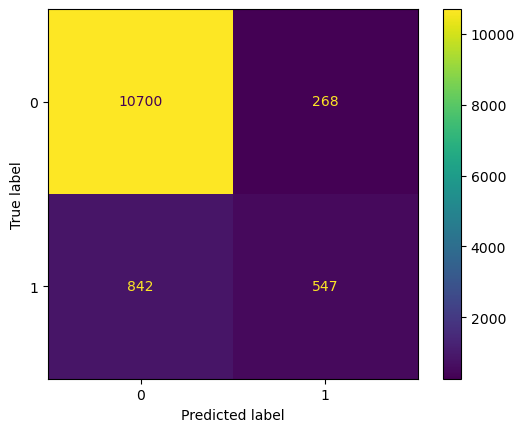

In [33]:
y_test_pred1 = reg.predict(x_test)

print(classification_report(y_test, y_test_pred1))

matrix = confusion_matrix(y_test, y_test_pred1)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

In [138]:
param_grid = {'gamma': [0.1, 1, 10],
              'C': [1, 5, 10],
              'kernel': ['linear']}

clf = SVC()

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='recall')

grid_search.fit(x_train, y_train)

print("Mejores hiperparámetros: ", grid_search.best_params_)
print("Rendimiento del modelo final: ", grid_search.best_score_)

Mejores hiperparámetros:  {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Rendimiento del modelo final:  0.3857251565638663


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     25580
           1       0.62      0.38      0.47      3251

    accuracy                           0.90     28831
   macro avg       0.77      0.68      0.71     28831
weighted avg       0.89      0.90      0.89     28831

mse: 0.09659741250737054


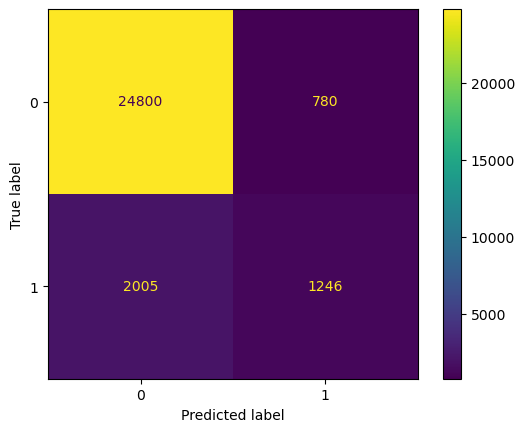

In [139]:
#Entrenamos y medimos un modelo de Clasificación SVM

clf = SVC(kernel='linear', C=1, gamma= 0.1)

clf.fit(x_train,y_train)

y_train_pred1 = clf.predict(x_train)

print(classification_report(y_train, y_train_pred1))

matrix = confusion_matrix(y_train, y_train_pred1)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10968
           1       0.62      0.38      0.47      1389

    accuracy                           0.90     12357
   macro avg       0.77      0.67      0.71     12357
weighted avg       0.89      0.90      0.89     12357

mse: 0.09581613660273529


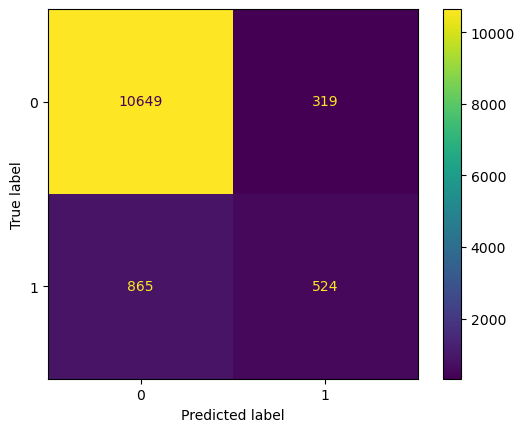

In [140]:
#Probamos el modelo con el dataset de testeo

y_test_pred1 = clf.predict(x_test)

print(classification_report(y_test, y_test_pred1))

matrix = confusion_matrix(y_test, y_test_pred1)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

In [133]:
param_grid = {'max_depth': [3, 5, 7, 10 ,15],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'criterion': ['gini', 'entropy', 'log_loss']}

clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='recall')

grid_search.fit(x_train, y_train)

print("Mejores hiperparámetros: ", grid_search.best_params_)
print("Rendimiento del modelo final: ", grid_search.best_score_)

Mejores hiperparámetros:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Rendimiento del modelo final:  0.5835179014533853


              precision    recall  f1-score   support

           0       0.95      0.95      0.95     25580
           1       0.59      0.59      0.59      3251

    accuracy                           0.91     28831
   macro avg       0.77      0.77      0.77     28831
weighted avg       0.91      0.91      0.91     28831

mse: 0.09174152821615622


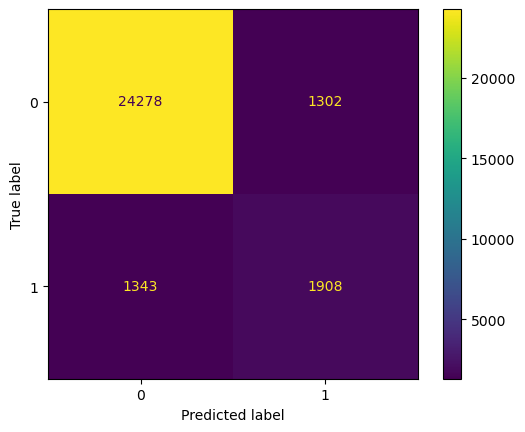

In [134]:
#Entrenamos y medimos un modelo de Clasificación de Árbol

clf = DecisionTreeClassifier (max_depth = 3 , min_samples_leaf= 1 , min_samples_split= 2, criterion='gini')

clf.fit(x_train,y_train)

y_train_pred2 = clf.predict(x_train)


print(classification_report(y_train, y_train_pred2))

matrix = confusion_matrix(y_train, y_train_pred2)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     10968
           1       0.60      0.59      0.59      1389

    accuracy                           0.91     12357
   macro avg       0.77      0.77      0.77     12357
weighted avg       0.91      0.91      0.91     12357

mse: 0.0903941086024116


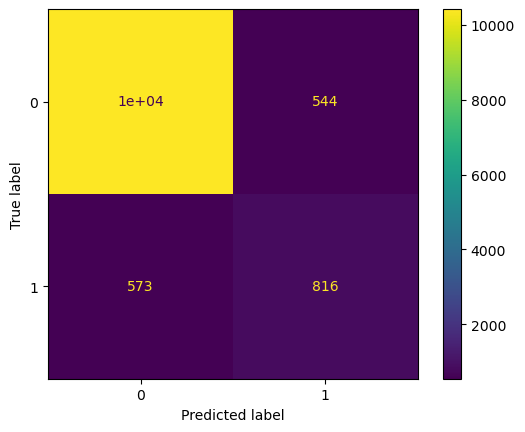

In [135]:
#Probamos el modelo con el dataset de testeo

y_test_pred2 = clf.predict(x_test)

print(classification_report(y_test, y_test_pred2))

matrix = confusion_matrix(y_test, y_test_pred2)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     25580
           1       0.44      0.42      0.43      3251

    accuracy                           0.87     28831
   macro avg       0.68      0.68      0.68     28831
weighted avg       0.87      0.87      0.87     28831

mse: 0.1267038951128993


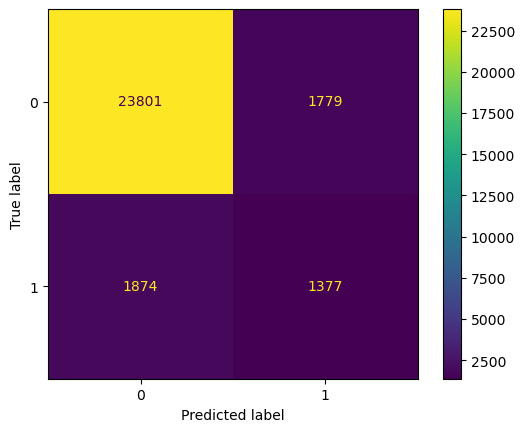

In [42]:
#Entrenamos y medimos un modelo Naive-Bayes

clf = GaussianNB()

clf.fit(x_train,y_train)

y_train_pred3 = clf.predict(x_train)


print(classification_report(y_train, y_train_pred3))

matrix = confusion_matrix(y_train, y_train_pred3)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10968
           1       0.45      0.44      0.44      1389

    accuracy                           0.88     12357
   macro avg       0.69      0.68      0.69     12357
weighted avg       0.88      0.88      0.88     12357

mse: 0.12268349923120499


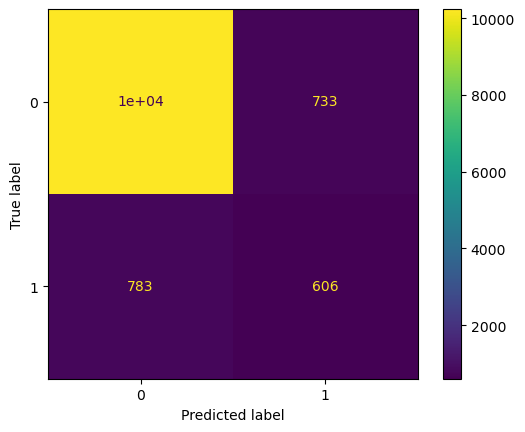

In [43]:
#Probamos el modelo con el dataset de testeo

y_test_pred3 = clf.predict(x_test)

print(classification_report(y_test, y_test_pred3))
print('mse:',mean_squared_error(y_test,y_test_pred3))

matrix = confusion_matrix(y_test, y_test_pred3)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

# Resultados:

## Análisis:

Partimos de un dataset con 41188 registros de los cuales el 11%, 4640 clientes, han suscripto a un depósito a plazo fijo.


Destacaremos del análisis algunos puntos sobre la efectividad de las ventas de Plazos Fijos:

Resulta favorable:

* Una mayor duración de la llamada, siendo un buen objetivo la barrera de los 4 minutos.
* Contactar a un cliente que ya ha formado parte de campañas previas.
* La venta a clientes menores a 30 años o mayores a 60 años.
* Contactar estudiantes o jubilados.
* Contactar por celular en vez de por teléfono.
* Realizar las campañas en épocas donde se reduce la tasa de empleo.

Resulta desfavorable:

* Contactar más de 3 veces al mismo cliente durante una campaña.
* Contactar trabajadores manuales.

## Modelo:

En base a los modelos decidimos quedarnos con el de Árbol (2do), el cual logra una clasificación más exacta.
No obstante remarcamos dos oportunidades de mejora:La optimización de hiperparámetros (hubo dificultades y no se pudo concretar) y la utilización de variables calculadas en la numeración de variables, la cual actualmente no es escalable y debe ajustarse manualmente.